In [1]:
import ee
import geemap

# Autenticar e inicializar (solo es necesario hacerlo una vez)
# ee.Authenticate()
ee.Initialize()


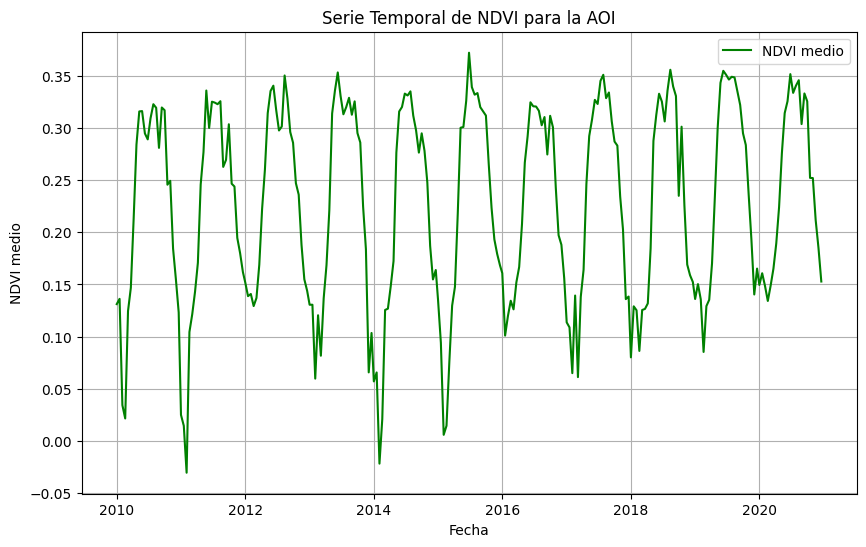

In [3]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

# Inicializa la librería de Earth Engine
ee.Initialize()

# Define el área de interés (AOI) como una geometría
aoi = ee.Geometry.Rectangle([-74.0365, 40.7128, -73.9356, 40.8495])  # Ejemplo: Área alrededor de Nueva York

# Selecciona el conjunto de datos y el rango de fechas
dataset = ee.ImageCollection('MODIS/006/MOD13Q1') \
            .filterDate('2010-01-01', '2020-12-31') \
            .filterBounds(aoi) \
            .select('NDVI')

# Función para convertir el valor de NDVI a una escala de 0 a 1
def scaleNDVI(image):
    return image.multiply(0.0001).set('system:time_start', image.get('system:time_start'))

# Escala los valores de NDVI
scaledNDVI = dataset.map(scaleNDVI)

# Crea una serie temporal de valores medios de NDVI para la AOI
def createTimeSeries(image):
    mean = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi, scale=250).get('NDVI')
    date = image.get('system:time_start')
    return ee.Feature(None, {'mean': mean, 'date': ee.Date(date).format('YYYY-MM-dd')})

# Aplica la función a la colección de imágenes
timeSeries = scaledNDVI.map(createTimeSeries)

# Extrae los datos usando getInfo() y conviértelos en un DataFrame de Pandas
timeSeriesList = timeSeries.getInfo()['features']
data = {'date': [], 'NDVI': []}
for feature in timeSeriesList:
    data['date'].append(feature['properties']['date'])
    data['NDVI'].append(feature['properties']['mean'])
df = pd.DataFrame(data)

# Convierte las cadenas de fecha a datetime y ordena el DataFrame
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Graficar la serie temporal de NDVI
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['NDVI'], label='NDVI medio', color='green')
plt.xlabel('Fecha')
plt.ylabel('NDVI medio')
plt.title('Serie Temporal de NDVI para la AOI')
plt.legend()
plt.grid(True)
plt.show()
